# 1. Automotive Cybersecurity - A Cold Start Problem

As automotive vehicles are increasingly connected, they face higher risk of being compromised. Especially, their in-vehicle networks are prone to attacks due to original designs with no security concerns in mind and one of the most common attacks is injecting messages to a vehicle’s CAN Bus.

In fact, this received [widespread media attention in 2015](https://www.wired.com/2015/07/hackers-remotely-kill-jeep-highway/) that a Senate bill was proposed in 2015 and [recently reintroduced in 2019](https://www.markey.senate.gov/news/press-releases/senators-markey-and-blumenthal-reintroduce-legislation-to-protect-cybersecurity-on-aircrafts-and-in-cars) to "ensure cybersecurity in increasingly computerized vehicles".

Similar threats exist for aircrafts, smart factories, smart buildings, and of course, the increasing number of IoT appliances. But let’s focus on automotive cybersecurity in this tutorial.

<img src="https://h1st-static.s3.amazonaws.com/cyberattacks.png" alt="Cyberattaks" />

Two of the proposed requirement in the SPY Car act are:
  * All  entry  points  to  the  electronic  systems  of  each  motor  vehicle  manufactured  for  sale  in  the  United  States  shall  be  equipped  with  reasonable  measures  to  protect  against hacking attacks
  * Any  motor  vehicle  manufactured  for  sale  in  the  United  States  that  presents  an  entry  point  shall  be  equipped  with  capabilities  to  immediately  detect,  report,  and  stop  attempts  to  intercept  driving data or control the vehicle

It is not obvious that such intrusion detection system (IDS) could work, but it turns out that with careful system design, we can construct it with Human1st.AI. The nature of CAN bus data and vehicle operations is that the normal traffic is highly regular (unlike an open node on the internet) and we can leverage this to build an IDS.

Let's dive in!

### 1a. CAN data basics

Let's familiarize ourselves with vehicle data.

Controller Area Network (CAN Bus) is a common in-vehicle network architecture. It was designed to avoid massive physical wires between Engine Control Units (ECUs) in a vehicle. A CAN packet (also called message)’s payload contains data from one or more ECUs which we refer to as sensors such as Car Speed, Steering Wheel’s Angle, Yaw Rate, Longitudinal Acceleration (Gx), Latitudinal Acceleration (Gy).

CAN Bus’ simple communication protocol makes it vulnerable to cyber-attacks due to security issues such as message broadcasting, no authentication, etc. Injection attacks are common to CAN Bus.


```{note}
All the tutorial notebooks and code is available from the H1st Github project at [https://github.com/h1st-ai/h1st/tree/master/examples/AutoCyber](https://github.com/h1st-ai/h1st/tree/master/examples/AutoCyber).

Simply go ahead and clone it, then follow along.

The following dataset is originally based on [https://zenodo.org/record/3267184#.XpHta1NKhQJ](https://zenodo.org/record/3267184#.XpHta1NKhQJ) with important processing done by Arimo. The reason is that recreating realistic message frequency for each CAN ID is crucial for this problem. Simply following along the tutorial would help you understand why this is needed.
```

For convenient, we provides a utility function to download this dataset which is about ~200MB in size.

In [1]:
import utils
data_files = utils.load_data()

In [2]:
data_files['attack_files'][:5]

['data/attack-samples/20181116_Driver1_Trip4-1.parquet',
 'data/attack-samples/20181203_Driver1_Trip9-2.parquet',
 'data/attack-samples/20181116_Driver1_Trip4-0.parquet',
 'data/attack-samples/20181214_Driver3_Trip7-2.parquet',
 'data/attack-samples/20181203_Driver1_Trip9-1.parquet']

In [3]:
import pandas as pd
import numpy as np

df = pd.read_parquet('data/attack-samples/20181116_Driver1_Trip4-0.parquet')

df.head(20)

,Timestamp,SteeringAngle,CarSpeed,YawRate,Gx,Gy,Label,AttackSensor,AttackMethod,AttackParams,AttackEventIndex
0,0.013574,67.604385,NaN,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>
1,0.024278,NaN,NaN,0.189777,0.002458,-0.002173,Normal,NA,NA,0.0,<NA>
2,0.024343,NaN,0.0,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>
3,0.027083,67.608772,NaN,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>
4,0.037508,NaN,NaN,0.189665,0.002375,-0.002151,Normal,NA,NA,0.0,<NA>
5,0.038148,67.613159,NaN,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>
6,0.043605,67.617538,NaN,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>
7,0.045474,NaN,0.0,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>
8,0.048622,NaN,NaN,0.189554,0.002292,-0.002130,Normal,NA,NA,0.0,<NA>
9,0.056639,67.621925,NaN,NaN,NaN,NaN,Normal,NA,NA,0.0,<NA>


Note that the data has a particular rhythm to it: each non-NA CarSpeed or YawRate comes at a regular interval, and YawRate/Gx/Gy messages always come with each other. In technical parlance, these are 3 different CAN IDs with different message payloads.

### 1b. Simulating attacks

Now comes the hard & fun part, as we only have normal data. How can we develop an intrusion detection system?

The first natural step is to generate attack data. There are many ways to simulate such attacks but the cheapest method is simply to inject fake messages into the stored data stream.

A more realistic (and also more expensive) method to safely simulate attacks is to inject messages directly into the CAN bus while vehicle is stationary (engine on/transmission in park), or when vehicle is in motion in a controlled driving environment / test track [such as conducted by the NHTSA](https://rosap.ntl.bts.gov/view/dot/41006)

For convenience, we have provided some synthetic samples (they are generated using the `aegis_datagen.py`). We can visualize one such attack as follow.

In [4]:
SENSORS = ["SteeringAngle", "CarSpeed", "YawRate", "Gx", "Gy"]

df.loc[df.AttackEventIndex == 3, ["Timestamp", "Label", "AttackSensor"] + SENSORS].head(20)

,Timestamp,Label,AttackSensor,SteeringAngle,CarSpeed,YawRate,Gx,Gy
48734,216.321254,Normal,NA,NaN,NaN,0.132825,-0.040180,-0.127843
48735,216.323931,Normal,NA,NaN,NaN,0.134205,-0.037794,-0.128857
48736,216.326549,Normal,NA,NaN,46.249397,NaN,NaN,NaN
48737,216.330955,Normal,NA,2.3928,NaN,NaN,NaN,NaN
48738,216.333062,Attack,YawRate,NaN,NaN,0.131447,-0.037794,-0.128857
48739,216.335049,Normal,NA,NaN,NaN,0.135585,-0.035409,-0.129870
48740,216.342751,Normal,NA,2.4144,NaN,NaN,NaN,NaN
48741,216.344695,Attack,YawRate,NaN,NaN,0.131461,-0.035409,-0.129870
48742,216.348972,Normal,NA,NaN,46.203197,NaN,NaN,NaN
48743,216.349076,Normal,NA,NaN,NaN,0.136965,-0.033023,-0.130883


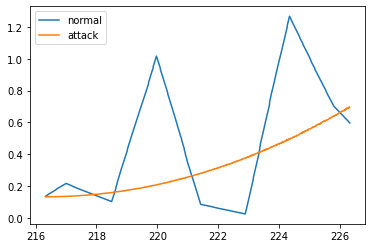

In [5]:
z = df[df.AttackEventIndex == 3]
yr = z[(z.Timestamp > z.Timestamp.min()) & (z.Timestamp < z.Timestamp.min()+10)].dropna(subset=["YawRate"])
import matplotlib.pyplot as plt
att = yr[yr["Label"] == "Attack"]
normal = yr[yr["Label"] == "Normal"]
plt.plot(normal.Timestamp, normal.YawRate, label="normal")
plt.plot(att.Timestamp, att.YawRate, label="attack")
plt.legend()

The key question is can ML/AD system detect the injected messages from the normal ones?